In [1]:
import datetime
import os
import backtrader as bt

In [2]:
class MyStrat(bt.Strategy):
    
    def __init__(self):
        self.bracket_orders = []
        
    def next(self):
        # bracket order on spy
        if not self.positionsbyname['spy'] and not self.open_orders_by_dname['spy']:
            spy = self.dnames['spy']
            buyprice = spy.close[0] * .98
            stopprice = buyprice * .96
            limitprice = buyprice * 1.1
            buy_bracket = self.buy_bracket(data=spy, size=20, price=buyprice, stopprice=stopprice, limitprice=limitprice)
            self.bracket_orders.append(buy_bracket)
    
    @property
    def open_orders_by_dname(self):
        '''return dictionary with data names as keys and corresponding open orders as values'''
        oobd = {data._name: [] for data in self.datas}
        for order in self.broker.get_orders_open():
            oobd[order.data._name].append(order)
        return oobd

In [3]:
cerebro = bt.Cerebro()

cerebro.addstrategy(MyStrat)

fromdate, todate = datetime.datetime(2019, 6, 15), datetime.datetime(2020, 6, 1)
folder = 'ETF'
for file in os.listdir(folder):
    dn = os.path.join(folder, file)
    data = bt.feeds.GenericCSVData(
        dataname=dn,
        fromdate=fromdate,
        todate=todate,
        nullvalue=0.0,
        dtformat=('%m/%d/%Y'),
        datetime=0,
        high=3,
        low=4,
        open=1,
        close=2,
        volume=5,
        openinterest=-1
    )
    cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.Transactions)
cerebro.broker.setcash(10000)
cerebro.broker.set_coc(True)
results = cerebro.run()
strat = results[0]
cerebro.broker.getvalue()

9891.50584

In [4]:
len(strat.bracket_orders)

8

In [5]:
# buy bracket is 3 orders, one buy, one sell stop, one sell limit
strat.bracket_orders[0]

In [6]:
# in this example: buy (limit order) was completed, sell limit was completed, so sell stop was canceled
for order in strat.bracket_orders[0]:
    print(order.data._name)
    print(order, '\n\n')

spy
Ref: 1
OrdType: 0
OrdType: Buy
Status: 4
Status: Completed
Size: 20
Price: 283.5826
Price Limit: None
TrailAmount: None
TrailPercent: None
ExecType: 2
ExecType: Limit
CommInfo: <backtrader.comminfo.CommInfoBase object at 0x0000015AC7A1CD68>
End of Session: 737227.9999999999
Info: AutoOrderedDict()
Broker: None
Alive: False 


spy
Ref: 2
OrdType: 1
OrdType: Sell
Status: 5
Status: Canceled
Size: -20
Price: 272.239296
Price Limit: None
TrailAmount: None
TrailPercent: None
ExecType: 3
ExecType: Stop
CommInfo: None
End of Session: 737227.9999999999
Info: AutoOrderedDict()
Broker: None
Alive: False 


spy
Ref: 3
OrdType: 1
OrdType: Sell
Status: 4
Status: Completed
Size: -20
Price: 311.94086000000004
Price Limit: None
TrailAmount: None
TrailPercent: None
ExecType: 2
ExecType: Limit
CommInfo: <backtrader.comminfo.CommInfoBase object at 0x0000015AC7A1CD68>
End of Session: 737227.9999999999
Info: AutoOrderedDict()
Broker: None
Alive: False 




<IPython.core.display.Javascript object>


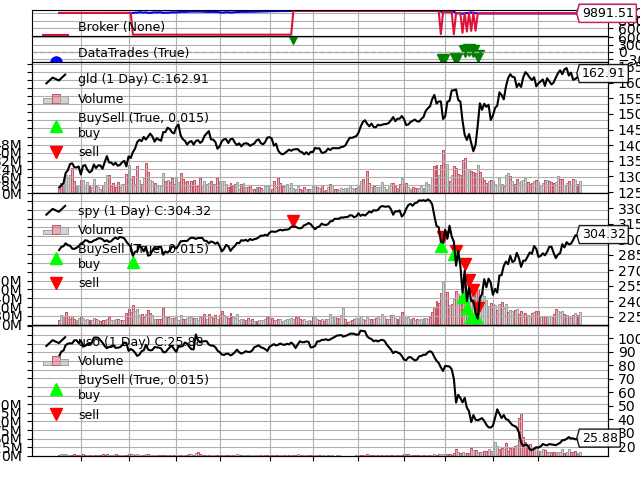

[[<Figure size 640x480 with 8 Axes>]]

In [7]:
cerebro.plot()

Manual issuing of bracket order involves using the keyword arguments "transmit" and "parent" inside the buy and sell methods
https://www.backtrader.com/docu/order-creation-execution/bracket/bracket/#manual-issuing-of-a-bracket